In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [10]:
import numpy as np
import pandas as pd
import xarray as xr
import datetime
import os
import re
from tqdm import tqdm
%matplotlib inline
import warnings
import glob
warnings.simplefilter(action='ignore', category=FutureWarning)
#Last edited: 2024029 by JS
import poligrain as plg
import matplotlib.pyplot as plt
# Import from "/src/pypwsqc" does not work
import sys
sys.path.append('/home/IWS/seidel/github/pypwsqc/src/pypwsqc')
import pwspyqc_dev_js as pyqc
import pickle
import dask

In [11]:

def fz_filter(
    pws_data: xr.DataArray,
    nbrs_not_nan: xr.DataArray,
    reference: xr.DataArray,
    nint: int,
    n_stat=int,
) -> xr.DataArray:
    """Faulty Zeros filter.

    This function applies the FZ filter from the R package PWSQC,
    flagging erroneous observations of zero rainfall.

    The Python code has been translated from the original R code,
    to be found here: https://github.com/LottedeVos/PWSQC/tree/master/R.

    The function returns an array with zeros, ones or -1 per time step
    and station.

    The flag 0 means that no faulty zero has been detected.
    The flag 1 means that faulty zero has been detected.
    The flag -1 means that no flagging was done because not enough
    neighbouring stations are reporting rainfall to make a reliable
    evaluation.

    Parameters
    ----------
    pws_data (xr.DataArray)
        The rainfall time series of the PWS that should be flagged
    nbrs_not_nan (xr.DataArray)
        Number of neighbouring stations reporting rainfall
    reference (xr.DataArray)
        The rainfall time series of the reference, which can be e.g.
        the median of neighboring stations
    nint (integer)
        The number of subsequent data points which have to be zero, while
        the reference has values larger than zero, to set the flag for
        this data point to 1.
    n_stat (integer)
        Threshold for number of neighbours reporting rainfall

    Returns
    -------
    xr.DataArray
        time series of flags
    """
    # initialize
    sensor_array = np.empty_like(pws_data)
    ref_array = np.empty_like(pws_data)
    fz_array = np.empty_like(pws_data)

    # Wet timestep at each station
    sensor_array[np.where(pws_data > 0)] = 1

    # Dry timestep at each station
    sensor_array[np.where(pws_data == 0)] = 0

    # Wet timesteps of the reference
    ref_array[np.where(reference > 0)] = 1

    for i in np.arange(len(pws_data.id.data)):
        for j in np.arange(len(pws_data.time.data)):
            if j < nint:
                fz_array[i, j] = -1
            elif sensor_array[i, j] > 0:
                fz_array[i, j] = 0
            elif fz_array[i, j - 1] == 1:
                fz_array[i, j] = 1
            elif (np.sum(sensor_array[i, j - nint : j + 1]) > 0) or (
                np.sum(ref_array[i, j - nint : j + 1]) < nint + 1
            ):
                fz_array[i, j] = 0
            else:
                fz_array[i, j] = 1

    fz_array = fz_array.astype(int)
    return xr.where(nbrs_not_nan < n_stat, -1, fz_array)


def hi_filter(
    pws_data: xr.DataArray,
    nbrs_not_nan: xr.DataArray,
    reference: xr.DataArray,
    hi_thres_a: int,
    hi_thres_b: int,
    n_stat=int,
) -> xr.DataArray:
    """High Influx filter.

    This function applies the HI filter from the R package PWSQC,
    flagging unrealistically high rainfall amounts.

    The Python code has been translated from the original R code,
    to be found here: https://github.com/LottedeVos/PWSQC/tree/master/R.

    The function returns an array with zeros, ones or -1 per time step
    and station.
    The flag 0 means that no high influx has been detected.
    The flag 1 means that high influx has been detected.
    The flag -1 means that no flagging was done because not enough
    neighbouring stations are reporting rainfall to make a reliable
    evaluation.

    Parameters
    ----------
    pws_data (xr.DataArray)
        The rainfall time series of the PWS that should be flagged
    nbrs_not_nan (xr.DataArray)
        Number of neighbouring stations reporting rainfall
    reference (xr.DataArray)
        The rainfall time series of the reference, which can be e.g.
        the median of neighboring stations
    hi_thres_a (integer)
        Threshold for median rainfall of neighbouring stations [mm]
    hi_thres_b (integer)
        Upper rainfall limit [mm]
    n_stat (integer)
        Threshold for number of neighbours reporting rainfall

    Returns
    -------
    xr.DataArray
        time series of flags
    """
    condition1 = (reference < hi_thres_a) & (pws_data > hi_thres_b)
    condition2 = (reference >= hi_thres_a) & (
        pws_data > reference * hi_thres_b / hi_thres_a
    )

    hi_array = (condition1 | condition2).astype(int)
    return xr.where(nbrs_not_nan < n_stat, -1, hi_array)

In [ ]:
def indicator_correlation_filter(
    indicator_correlation_matrix_ref,
    distance_correlation_matrix_ref,
    indicator_correlation_matrix, 
    distance_matrix, 
    max_distance=20e3, 
    bin_size=1e3,
    quantile_bin_ref=0.1,
    quantile_bin_pws=0.5,
    threshold=0.01
):
    """Apply indicator correlation filer to filter out PWS that do not match the correlation structure of
    reference data set.

    Parameters
    ----------
    indicator_correlation_matrix_ref:
    distance_correlation_matrix_ref:
    indicator_correlation_matrix: xr.DataArray with Indicator Correlations between REF and PWS
    distance_matrix: xr.DataArray with distance between REF and PWS
    range: range in meters for which the indicator correlation is evaluated
    bin_size: bin size in meters
    acceptance_level: quantile for acceptance level of reference indicator correlation
    threshold: indicator correlation threshold below acceptance level where PWS are still accepted

    Returns
    -------
    boolean if station got accepted
    indicator correlation score
    """
    bins = np.arange(0, max_distance, bin_size)

    # quantile parameter not too low, otherwise the line becomes to wiggly - depends on data
    binned_indcorr_ref = indicator_correlation_matrix_ref.groupby_bins(
        distance_correlation_matrix_ref, bins=bins
    ).quantile(quantile_bin_ref).bfill(dim='group_bins')

    #Function for Rank Sum Weights
    #Calculates weights according to length to data set 
    def rsw(m):
        alphas = []  # Leere Liste
        for i in range(1, m+1):  # Iteration über m Alternativen
            alpha = (m + 1. - i) / sum(range(1, m+1))
            alphas.append(alpha)
        return alphas
    
    pws_indcorr_good_list = []
    pws_indcorr_score_list = []

    # iterates over REF (id)
    for pws_id in indicator_correlation_matrix['id_neighbor'].values:
        binned_indcorr_pws = indicator_correlation_matrix.sel(id_neighbor=pws_id).groupby_bins(
        distance_matrix.sel(id_neighbor=pws_id), bins=bins
        ).quantile(quantile_bin_pws)

        IndCorrGood = (binned_indcorr_pws + threshold > binned_indcorr_ref)
        
        # Bool Information if PWS passed Indicator Correlation Test
        pws_indcorr_good_list.append(IndCorrGood.any())
        
        # Valid bins for normed weights
        ValidBins = np.isfinite(binned_indcorr_pws.values)
        RankSumWeights = rsw(len(IndCorrGood))
        NormedWeights = sum(ValidBins * np.array(RankSumWeights))
        
        score = sum(IndCorrGood.values * np.array(RankSumWeights)) / NormedWeights
        pws_indcorr_score_list.append(score)

    foo = indcorr_mtx_ref_pws.to_dataset(name='indcorr')
    foo['dist'] = dist_mtx_ref_pws
    foo['indcorr_good'] = (('id_neighbor', pws_indcorr_good_list))
    foo['indcorr_score'] = (('id_neighbor', pws_indcorr_score_list))
    foo

    return foo

In [12]:
#ds_pws = xr.open_dataset("/home/IWS/seidel/PWS_data/AMS/AMS_PWS_1h_res.nc")
#ds_pws_5min = xr.open_dataset("/home/IWS/seidel/PWS_data/AMS/OpenSense_PWS_example_format_data.nc")
#ds_pws = xr.open_dataset("/home/IWS/seidel/PWS_data/RT_pws_res_1h/PWS_Reutlingen_v1.nc")
ds_pws = xr.open_dataset(r'/home/IWS/seidel/PWS_code/PWS_Lazio/PWS_Lazio_1h.nc')
#ds_pws= xr.open_dataset('/home/IWS/seidel/PWS_data/EGLV_nc/EGLV_PWS_1h_v3.nc')

In [13]:
ds_pws.load()

<xarray.Dataset>
Dimensions:      (id: 339, time: 73913)
Coordinates:
  * id           (id) <U13 'Lazio_PWS_001' 'Lazio_PWS_002' ... 'Lazio_PWS_339'
  * time         (time) datetime64[ns] 2014-12-31T23:00:00 ... 2023-06-07T15:...
    elevation    (id) float64 37.0 38.0 55.0 52.0 ... 3.0 1.048e+03 361.0 104.0
    longitude    (id) float64 12.53 12.49 12.43 12.61 ... 13.33 12.11 12.65
    latitude     (id) float64 41.94 41.82 41.84 41.49 ... 41.89 42.43 41.96
    mac_address  (id) <U17 '70_ee_50_00_0d_38' ... '70_ee_50_96_ec_54'
Data variables:
    rainfall     (time, id) float64 0.0 nan nan 0.0 nan ... nan nan nan nan nan
Attributes:
    title:         PWS data from Lazio Region
    institution:   Sapienza University
    history:       Test Version 1
    references:    N/A
    date_created:  2024-09-12 10:50:45
    Conventions:   OPENSENSE V0
    location:      Rome/Lazio
    source:        Netatmo
    comment:       naming convention OpenSense v0, resampled to 1h from origi...

In [14]:
#ds_pws=ds_pws_5min.resample(time='1h').sum(skipna=True, min_count=10)
#ds_pws.to_netcdf('AMS_PWS_1h_res.nc')

In [15]:
ds_pws.coords['x'], ds_pws.coords['y'] = plg.spatial.project_point_coordinates(
     ds_pws.longitude, ds_pws.latitude, target_projection="EPSG:25832",
 )

#ds_pws.coords['x'], ds_pws.coords['y'] = plg.spatial.project_point_coordinates(
#    ds_pws.longitude, ds_pws.latitude, target_projection="EPSG:25832",
#)

In [16]:
ds_pws.isel(id=0)

<xarray.Dataset>
Dimensions:      (time: 73913)
Coordinates:
    id           <U13 'Lazio_PWS_001'
  * time         (time) datetime64[ns] 2014-12-31T23:00:00 ... 2023-06-07T15:...
    elevation    float64 37.0
    longitude    float64 12.53
    latitude     float64 41.94
    mac_address  <U17 '70_ee_50_00_0d_38'
    x            float64 7.926e+05
    y            float64 4.649e+06
Data variables:
    rainfall     (time) float64 0.0 0.0 0.0 0.0 0.0 0.0 ... nan nan nan nan nan
Attributes:
    title:         PWS data from Lazio Region
    institution:   Sapienza University
    history:       Test Version 1
    references:    N/A
    date_created:  2024-09-12 10:50:45
    Conventions:   OPENSENSE V0
    location:      Rome/Lazio
    source:        Netatmo
    comment:       naming convention OpenSense v0, resampled to 1h from origi...

In [17]:
dist_mtx_pws, indcorr_mtx_pws = pyqc.calc_indic_corr_all_stns(
    ds_pws.rainfall, 
    ds_pws.rainfall, 
    prob=0.99,
    max_distance=30e3,
    min_valid_overlap=4*24*30,
)

  0%|          | 0/339 [00:00<?, ?it/s]

  3%|▎         | 10/339 [00:10<03:42,  1.48it/s]/home/IWS/seidel/miniconda3/envs/opensense_sandbox/lib/python3.10/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/Users/chwala-c/code/pypwsqc/.venv/lib/python3.10/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
100%|██████████| 339/339 [04:58<00:00,  1.14it/s]


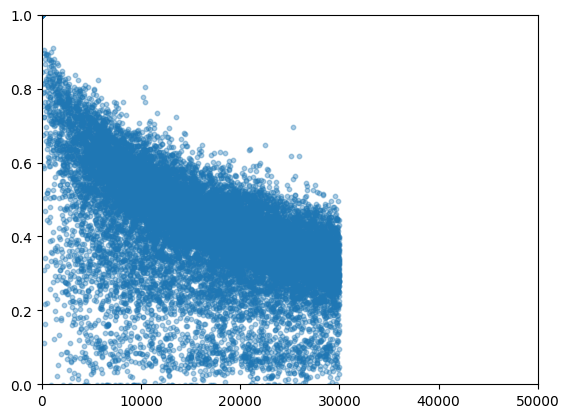

In [18]:
plt.scatter(dist_mtx_pws, indcorr_mtx_pws, alpha=0.2, s=10)
#plt.scatter(dist_mtx_ref, corr_mtx_ref, s=10)
plt.ylim(0, 1)
plt.xlim(0, 50e3);

In [19]:
dist_mtx_pws.to_netcdf((r'/home/IWS/seidel/PWS_code/PWS_Lazio/PWS_Lazio_distmtx.nc'))
indcorr_mtx_pws.to_netcdf((r'/home/IWS/seidel/PWS_code/PWS_Lazio/PWS_Lazio_corrmtx.nc'))

PermissionError: [Errno 13] Permission denied: '/home/IWS/seidel/PWS_code/PWS_Lazio/PWS_Lazio_distmtx.nc'

In [20]:
#ds_ref=xr.open_dataset("/home/IWS/seidel/PWS_data/AMS/RadarRef_AMS.nc")
ds_ref=xr.open_dataset(r'/home/IWS/seidel/PWS_code/PWS_Lazio/HydroNet_Lazio_60min.nc')
#ds_ref=xr.open_dataset("/home/IWS/seidel/RT_Pluviodata/10_netCDF_QC/Reutlingen_Pluviodata_2024_v2_1hourly_qc.nc")
ds_ref.load()
ds_ref.coords['x'], ds_ref.coords['y'] = plg.spatial.project_point_coordinates(
    ds_ref.longitude, ds_ref.latitude, target_projection="EPSG:25832",
)

In [21]:
dist_mtx_ref, indcorr_mtx_ref = pyqc.calc_indic_corr_all_stns(
    ds_ref.rainfall, 
    ds_ref.rainfall,
    max_distance=30e3, 
    prob=0.99,
    min_valid_overlap=4*24*30,)

  0%|          | 0/230 [00:00<?, ?it/s]

100%|██████████| 230/230 [01:02<00:00,  3.69it/s]


In [21]:
dist_mtx_ref.to_netcdf((r'/home/IWS/seidel/PWS_code/PWS_Lazio/HydroNet_Lazio_distmtx.nc'))
indcorr_mtx_ref.to_netcdf((r'/home/IWS/seidel/PWS_code/PWS_Lazio/HydroNet_Lazio_corrmtx.nc'))

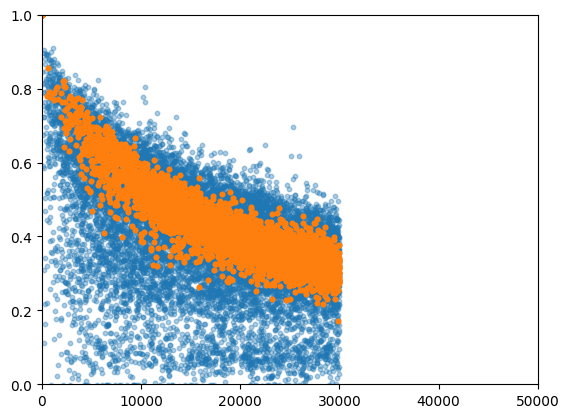

In [22]:
#plt.scatter(dist_vals, corr_vals, alpha=0.2, s=10)
plt.scatter(dist_mtx_pws, indcorr_mtx_pws, alpha=0.2, s=10)
plt.scatter(dist_mtx_ref, indcorr_mtx_ref, s=10)
plt.ylim(0, 1)
plt.xlim(0, 50e3);

In [354]:
# IMPORTANT !!!!!!!!!!!!
# I have switched the order of the first two arguments here
# so that dim `id` is the one of the PWS

dist_mtx_ref_pws, indcorr_mtx_ref_pws= pyqc.calc_indic_corr_all_stns(
    ds_ref.rainfall,#.sel(time=slice('2014-12-31T23:00:00','2023-10-31T03:00:00')), 
    ds_pws.rainfall,#.sel(time=slice('2014-12-31T23:00:00','2023-10-31T03:00:00')), 
    ds_ref.rainfall.shift(time=-1),#.sel(time=slice('2014-12-31T23:00:00','2023-10-31T03:00:00')), 
    prob=0.99,
    min_valid_overlap=4*24*30,)

  0%|          | 0/230 [00:00<?, ?it/s]

100%|██████████| 230/230 [03:54<00:00,  1.02s/it]


In [24]:
dist_mtx_ref_pws.to_netcdf((r'/home/IWS/seidel/PWS_code/PWS_Lazio/Lazio_distmtx_ref_pws.nc'))
indcorr_mtx_ref_pws.to_netcdf((r'/home/IWS/seidel/PWS_code/PWS_Lazio/Lazio_corrmtx_ref_pws.nc'))

If there is a 1h time shift in the data (UTC vs. MEZ) which should not be

`ds_ref.rainfall.shift(time=-1)`

Incdator corrlation for all stations does not fill the whole matrix, let's check out why!

    for i in tqdm.tqdm(range(len(xy_a))):
        for j in range(len(xy_b)):

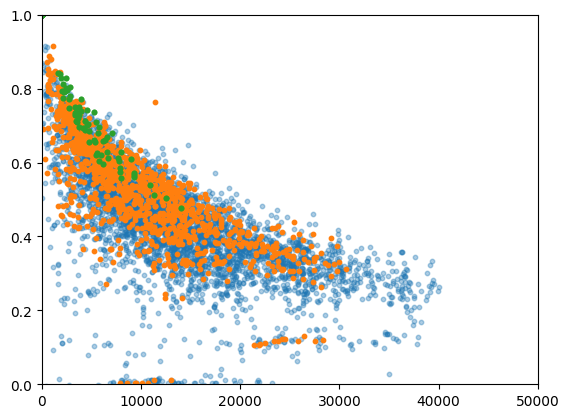

In [355]:
plt.scatter(dist_mtx_pws, indcorr_mtx_pws, alpha=0.2, s=10)
plt.scatter(dist_mtx_ref_pws, indcorr_mtx_ref_pws, s=10)
plt.scatter(dist_mtx_ref, indcorr_mtx_ref, s=10)
plt.ylim(0, 1)
plt.xlim(0, 50e3);

## WIP stuff with using `pandas` to bin and filter by indcorr

the stuff with `xarray` below is IMO better

<Axes: xlabel='dist'>

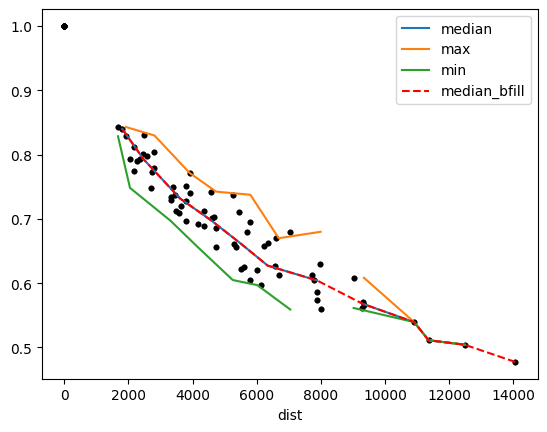

In [366]:
import pandas as pd

df = pd.DataFrame(
    {
        'dist': dist_mtx_ref.data.flatten(),
        'indcorr': indcorr_mtx_ref.data.flatten(),
    }
)
df = df.sort_values('dist')

#df = df.set_index('dist')

out = pd.cut(df.dist , bins=np.arange(0, 30e3, 1e3))

fig, ax = plt.subplots()
df.groupby(out).median().plot('dist', 'indcorr', ax=ax, label='median')
df.groupby(out).max().plot('dist', 'indcorr', ax=ax, label='max')
df.groupby(out).min().plot('dist', 'indcorr', ax=ax, label='min')
plt.scatter(dist_mtx_ref, indcorr_mtx_ref, s=10, color='k')

median_indcorr_filled = df.groupby(out).median().bfill()

median_indcorr_filled.plot('dist', 'indcorr', ax=ax, label='median_bfill', color='r', linestyle='--')


In [367]:
def bin_by_distance(dist, variable, bins):
    df = pd.DataFrame({'dist': dist, 'variable': variable})
    return df.variable.groupby(pd.cut(df.dist , bins=bins)).median().bfill()
    

bin_by_distance(dist=dist_mtx_ref.data.flatten(), variable=indcorr_mtx_ref.data.flatten(), bins=np.arange(0, 20e3, 1e3))

dist
(0.0, 1000.0]         0.839765
(1000.0, 2000.0]      0.839765
(2000.0, 3000.0]      0.793079
(3000.0, 4000.0]      0.731909
(4000.0, 5000.0]      0.697113
(5000.0, 6000.0]      0.660931
(6000.0, 7000.0]      0.627300
(7000.0, 8000.0]      0.604265
(8000.0, 9000.0]      0.568032
(9000.0, 10000.0]     0.568032
(10000.0, 11000.0]    0.539461
(11000.0, 12000.0]    0.511269
(12000.0, 13000.0]    0.504331
(13000.0, 14000.0]    0.477567
(14000.0, 15000.0]    0.477567
(15000.0, 16000.0]         NaN
(16000.0, 17000.0]         NaN
(17000.0, 18000.0]         NaN
(18000.0, 19000.0]         NaN
Name: variable, dtype: float64

## WIP stuff with `xarray` to bin and filter by indcorr

In [420]:
bins = np.arange(0, 30e3, 1e3)

binned_indcorr_ref = indcorr_mtx_ref.groupby_bins(
    dist_mtx_ref, bins=bins
).quantile(0.5).bfill(dim='group_bins')

binned_indcorr_ref

<xarray.DataArray (group_bins: 29)>
array([0.83976451, 0.83976451, 0.79307938, 0.73190945, 0.69711308,
       0.66093068, 0.62729987, 0.60426496, 0.5680317 , 0.5680317 ,
       0.53946114, 0.51126893, 0.5043306 , 0.47756705, 0.47756705,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan])
Coordinates:
  * group_bins  (group_bins) object (0.0, 1000.0] ... (28000.0, 29000.0]
    quantile    float64 0.5

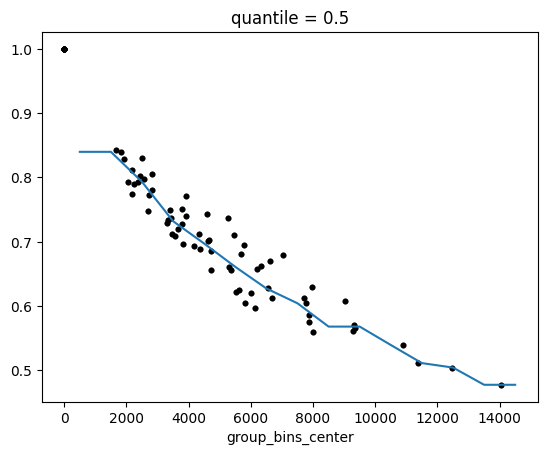

In [421]:
binned_indcorr_ref.plot()
plt.scatter(dist_mtx_ref, indcorr_mtx_ref, s=10, color='k')

In [422]:
pws_indcorr_good_list = []

for pws_id in indcorr_mtx_ref_pws.id.values:
    binned_indcorr_pws = indcorr_mtx_ref_pws.sel(id=pws_id).groupby_bins(
        dist_mtx_ref_pws.sel(id=pws_id), bins=bins
    ).median()
    pws_indcorr_good_list.append((binned_indcorr_pws + 0.02 > binned_indcorr_ref).any())

In [423]:
ds_pws['indcorr_good'] = xr.DataArray(
    data=pws_indcorr_good_list, 
    coords={'id': indcorr_mtx_ref_pws.id.values},
)

In [424]:
foo = indcorr_mtx_ref_pws.to_dataset(name='indcorr')
foo['dist'] = dist_mtx_ref_pws
foo['indcorr_good'] = (('id', pws_indcorr_good_list))
foo

<xarray.Dataset>
Dimensions:       (id: 101, id_neighbor: 12)
Coordinates:
  * id            (id) <U10 'RT_PWS_001' 'RT_PWS_002' ... 'RT_PWS_103'
  * id_neighbor   (id_neighbor) <U5 'RT_01' 'RT_02' 'RT_03' ... 'RT_11' 'RT_12'
Data variables:
    indcorr       (id, id_neighbor) float64 0.3068 0.3117 0.2955 ... 0.551 0.486
    dist          (id, id_neighbor) float64 2.499e+04 2.437e+04 ... 1.336e+04
    indcorr_good  (id) bool False False False False ... True True True True

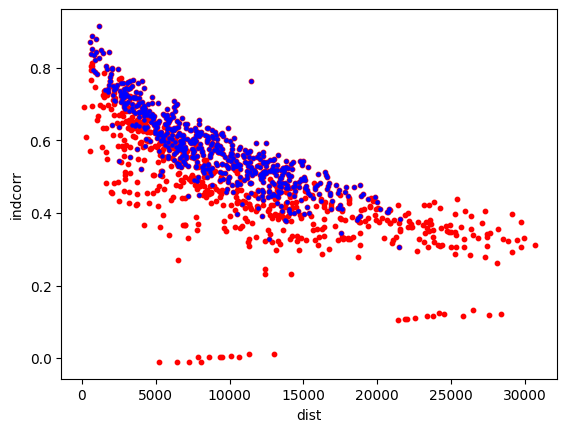

In [425]:
foo.plot.scatter(x='dist', y='indcorr', color='r', s=10)
foo.where(foo.indcorr_good).plot.scatter(x='dist', y='indcorr', color='b', s=5);

Thoughts for indicator correlation filter
- calculate corr_mtxs and dist_mtxs within function or as external input data (or both as options)
- different calcualtion for squared (PWS-PWS, REF-REF) or non-square (PWS-REF) 
- IndCorr to n-nearest REF Stations as parameter (e.g. 1-5)

Orgiginal Infocator Filter Algorithm 
- empty bool array form numer of stations (length of `id_neigbor`)
- interate over number of pws (`i`)
    + get pcp data from station `i`
    + drop NAN (required?)
    + get nearest/all primary stations
    + sort them according to distance
    + interate of number of primary stations from close to far (`j`)
        - check for suffcient overlapping data
        - calculate indcorr -> not required, can be taken from mtxs
        - va(?) does what? not clear
        - 



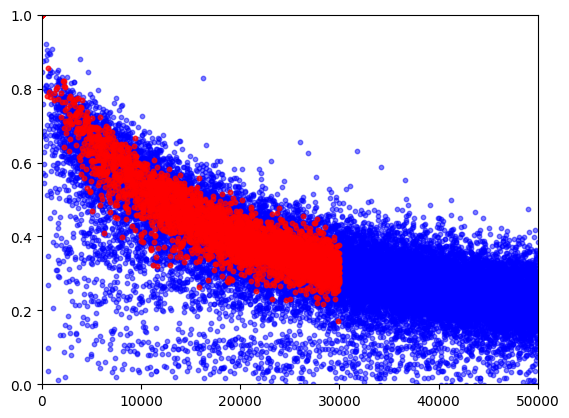

In [25]:
#plt.scatter(dist_vals, corr_vals, alpha=0.2, s=10)
#plt.scatter(dist_mtx_pws, indcorr_mtx_pws, alpha=0.2, s=10)
plt.scatter(dist_mtx_ref_pws, indcorr_mtx_ref_pws, color='b', alpha=0.5, s=10)
plt.scatter(dist_mtx_ref, indcorr_mtx_ref,  color='r', alpha=0.5, s=10)
#plt.scatter(dist_mtx_ref_pws, indcorr_mtx_ref_pws, s=10)
plt.ylim(0, 1)
plt.xlim(0, 50e3);


WIP stuff with `xarray` to bin and filter by indcorr


In [26]:
# Ideas to implement
# - get max range from dist_mtx_ref
# - threshold parameter
bins = np.arange(0, 20e3, 1e3)

# quantile parameter not too low, otherwise the line becomes to wiggly - depends on data
binned_indcorr_ref = indcorr_mtx_ref.groupby_bins(
    dist_mtx_ref, bins=bins
).quantile(0.1).bfill(dim='group_bins')

binned_indcorr_ref

<xarray.DataArray (group_bins: 19)>
array([0.77627563, 0.73636418, 0.66274276, 0.61969042, 0.58184797,
       0.56974701, 0.5207101 , 0.51713296, 0.50421813, 0.47934209,
       0.4671814 , 0.43114742, 0.42985217, 0.41046853, 0.39565731,
       0.37466827, 0.36524143, 0.36478882, 0.34686701])
Coordinates:
    quantile    float64 0.1
  * group_bins  (group_bins) object (0.0, 1000.0] ... (18000.0, 19000.0]

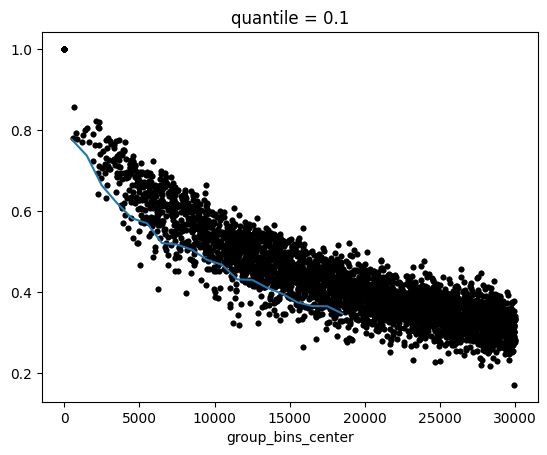

In [27]:
binned_indcorr_ref.plot()
plt.scatter(dist_mtx_ref, indcorr_mtx_ref, s=10, color='k')

In [28]:
pws_indcorr_good_list = []

# iterates over REF (id)
for pws_id in indcorr_mtx_ref_pws.id_neighbor.values:
    #print(pws_id)
    binned_indcorr_pws = indcorr_mtx_ref_pws.sel(id_neighbor=pws_id).groupby_bins(
        dist_mtx_ref_pws.sel(id_neighbor=pws_id), bins=bins
        ).quantile(0.1)
    #print (binned_indcorr_pws + 0.02 > binned_indcorr_ref.any())
    pws_indcorr_good_list.append((binned_indcorr_pws + 0.01 > binned_indcorr_ref).sum())
    #raise Exception

/home/IWS/seidel/miniconda3/envs/opensense_sandbox/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1545: RuntimeWarning: All-NaN slice encountered
  return _nanquantile_unchecked(
/home/IWS/seidel/miniconda3/envs/opensense_sandbox/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1545: RuntimeWarning: All-NaN slice encountered
  return _nanquantile_unchecked(
/home/IWS/seidel/miniconda3/envs/opensense_sandbox/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1545: RuntimeWarning: All-NaN slice encountered
  return _nanquantile_unchecked(
/home/IWS/seidel/miniconda3/envs/opensense_sandbox/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1545: RuntimeWarning: All-NaN slice encountered
  return _nanquantile_unchecked(
/home/IWS/seidel/miniconda3/envs/opensense_sandbox/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1545: RuntimeWarning: All-NaN slice encountered
  return _nanquantile_unchecked(
/home/IWS/seidel/miniconda3/envs/opensense_sandbox/lib/python3.10

In [29]:
ds_pws['indcorr_good'] = xr.DataArray(
    data=pws_indcorr_good_list, 
    coords={'id_neighbor': indcorr_mtx_ref_pws.id_neighbor.values},
)

In [30]:
ds_pws

<xarray.Dataset>
Dimensions:       (id: 339, time: 73913, id_neighbor: 339)
Coordinates:
  * id            (id) <U13 'Lazio_PWS_001' 'Lazio_PWS_002' ... 'Lazio_PWS_339'
  * time          (time) datetime64[ns] 2014-12-31T23:00:00 ... 2023-06-07T15...
    elevation     (id) float64 37.0 38.0 55.0 52.0 ... 3.0 1.048e+03 361.0 104.0
    longitude     (id) float64 12.53 12.49 12.43 12.61 ... 13.33 12.11 12.65
    latitude      (id) float64 41.94 41.82 41.84 41.49 ... 41.89 42.43 41.96
    mac_address   (id) <U17 '70_ee_50_00_0d_38' ... '70_ee_50_96_ec_54'
    x             (id) float64 7.926e+05 7.896e+05 ... 7.562e+05 8.027e+05
    y             (id) float64 4.649e+06 4.636e+06 ... 4.702e+06 4.651e+06
  * id_neighbor   (id_neighbor) <U13 'Lazio_PWS_001' ... 'Lazio_PWS_339'
Data variables:
    rainfall      (time, id) float64 0.0 nan nan 0.0 nan ... nan nan nan nan nan
    indcorr_good  (id_neighbor) int64 15 4 16 7 14 14 8 9 7 ... 14 6 0 0 5 0 0 0
Attributes:
    title:         PWS data from Lazio Region
    institution:   Sapienza University
    history:       Test Version 1
    references:    N/A
    date_created:  2024-09-12 10:50:45
    Conventions:   OPENSENSE V0
    location:      Rome/Lazio
    source:        Netatmo
    comment:       naming convention OpenSense v0, resampled to 1h from origi...

In [ ]:
indcorr_mtx_ref_pws.id_neighbor.values[0]

In [31]:
ds_pws.indcorr_good

<xarray.DataArray 'indcorr_good' (id_neighbor: 339)>
array([15,  4, 16,  7, 14, 14,  8,  9,  7,  8,  8, 11, 14,  8, 14,  2,  0,
        0, 10, 13, 13, 14, 13,  8, 12,  8, 16, 10, 11,  7,  9,  0,  8, 10,
        7, 14, 13,  1, 14,  3, 10, 10, 14, 13,  7, 10,  6, 10, 10, 11,  3,
        6,  0,  5,  0,  0,  0,  6,  6,  0,  8, 15, 14,  4,  5,  6, 10, 13,
       11, 15,  0,  7,  0, 10,  2, 17, 16, 10,  1,  8, 13, 12,  0, 16, 14,
        9, 11,  0,  6,  4,  7,  0,  3,  0,  3,  0, 16, 10,  4,  7,  9, 13,
        9, 14,  6,  7, 12,  7,  2, 14,  9,  0, 11, 11,  6,  0,  4,  3,  0,
        0, 15, 13, 12,  5,  6,  7, 11, 11, 17, 10,  8,  7,  6,  0, 10,  0,
       14,  3,  2,  7,  7,  0,  6,  8,  6,  0,  0,  8, 13, 13,  4,  6, 11,
       14,  8,  7,  7,  0,  6, 11,  8,  8,  7,  0,  2,  0, 15, 10,  0,  6,
        8, 14,  6, 17,  8, 12, 13,  4, 10,  7,  5,  7,  7,  8, 11,  5, 14,
       13,  7,  2,  9,  9, 14,  0,  1,  8,  2,  8, 13, 15,  4,  0,  0, 10,
        8,  5,  9,  0,  7,  6,  0, 15,  9, 12,  8,  4,  2,  0, 11,  3, 16,
        0, 14, 14, 15, 15, 10,  0,  6,  1,  6, 10,  6, 11,  6, 11,  4,  4,
       14, 16,  1, 12,  0,  0,  0, 16, 13,  8,  7,  8,  0, 13, 14,  6, 11,
       15,  3,  0,  0,  0,  0,  7,  5,  8,  0, 10, 15, 13, 10, 11,  5,  1,
        4, 12,  7,  0,  3, 13,  6,  4, 16,  6,  4,  3,  7, 15,  4,  0, 10,
        0,  8, 15,  8,  5,  0, 13, 11,  0,  0, 13,  4,  5,  4,  2,  5,  0,
       15,  7,  7,  2, 11, 10,  9,  9,  0,  6,  0, 12,  0,  7,  5,  1,  4,
        9, 11,  3,  0,  0,  8,  6,  8, 14,  6,  0,  0,  5,  0,  0,  0])
Coordinates:
  * id_neighbor  (id_neighbor) <U13 'Lazio_PWS_001' ... 'Lazio_PWS_339'

In [ ]:
ds_pws.indcorr_sum.values

In [25]:
foo = indcorr_mtx_ref_pws.to_dataset(name='indcorr')
foo['dist'] = dist_mtx_ref_pws
foo['indcorr_good'] = (('id_neighbor', pws_indcorr_good_list))
foo



<xarray.Dataset>
Dimensions:       (id: 230, id_neighbor: 339)
Coordinates:
  * id            (id) <U12 'HydroNet_001' 'HydroNet_002' ... 'HydroNet_230'
  * id_neighbor   (id_neighbor) <U13 'Lazio_PWS_001' ... 'Lazio_PWS_339'
Data variables:
    indcorr       (id, id_neighbor) float64 nan nan nan nan ... 0.3154 nan nan
    dist          (id, id_neighbor) float64 1.276e+05 1.369e+05 ... 2.044e+04
    indcorr_good  (id_neighbor) bool True True True True ... True True False

In [26]:
x=foo.id_neighbor[foo.indcorr_good]

In [27]:
foo.isel(id=27)

<xarray.Dataset>
Dimensions:       (id_neighbor: 339)
Coordinates:
    id            <U12 'HydroNet_028'
  * id_neighbor   (id_neighbor) <U13 'Lazio_PWS_001' ... 'Lazio_PWS_339'
Data variables:
    indcorr       (id_neighbor) float64 0.1498 nan nan nan ... 0.3263 nan nan
    dist          (id_neighbor) float64 4.802e+04 5.413e+04 ... 3.765e+04
    indcorr_good  (id_neighbor) bool True True True True ... True True False

KeyError: "not all values found in index 'id_neighbor'. Try setting the `method` keyword argument (example: method='nearest')."

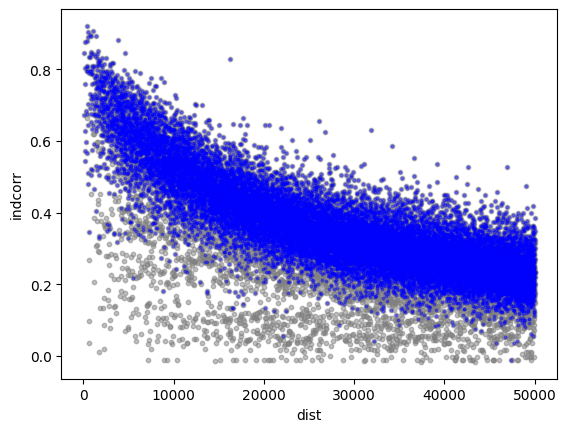

In [28]:
foo.plot.scatter(x='dist', y='indcorr', color='grey', alpha=0.5, s=10)
foo.where(foo.indcorr_good).plot.scatter(x='dist', y='indcorr', color='b', alpha=0.4, s=3)
foo.sel(id_neighbor='RT_PWS_012').plot.scatter(x='dist', y='indcorr', color='lime', alpha=0.4, s=15)
plt.scatter(dist_mtx_ref, indcorr_mtx_ref, color='r', s=10);

In [ ]:
for stn in foo.id_neighbor[foo.indcorr_good]:
    #foo.sel(id_neighbor=stn)
    foo.plot.scatter(x='dist', y='indcorr', color='grey', alpha=0.5, s=10)
    #foo.where(foo.indcorr_good).plot.scatter(x='dist', y='indcorr', color='b', alpha=0.4, s=3)
    
    plt.scatter(dist_mtx_ref, indcorr_mtx_ref, color='r', alpha=0.5, s=10)
    foo.sel(id_neighbor=stn).plot.scatter(x='dist', y='indcorr', color='lime', s=15)
    plt.savefig(str(stn.values)+'.png', dpi=200)#
    plt.close();





In [ ]:
str(stn.values)

In [ ]:
foo.where(foo.indcorr_good == 1, foo.indcorr_good, drop=True)

In [ ]:
foo

In [ ]:
# This is the list of accepted PWS (85) from the training school (tolerance 0.99)
stats_in = ['ams1', 'ams2', 'ams3', 'ams4', 'ams5', 'ams6', 'ams7', 'ams8', 'ams9',
       'ams10', 'ams12', 'ams13', 'ams14', 'ams15', 'ams17', 'ams18', 'ams19',
       'ams20', 'ams21', 'ams23', 'ams24', 'ams26', 'ams28', 'ams29', 'ams30',
       'ams31', 'ams32', 'ams33', 'ams34', 'ams35', 'ams36', 'ams39', 'ams40',
       'ams43', 'ams47', 'ams51', 'ams52', 'ams53', 'ams54', 'ams56', 'ams57',
       'ams62', 'ams65', 'ams66', 'ams69', 'ams71', 'ams72', 'ams75', 'ams78',
       'ams79', 'ams81', 'ams82', 'ams86', 'ams88', 'ams89', 'ams90', 'ams91',
       'ams94', 'ams95', 'ams96', 'ams98', 'ams100', 'ams101', 'ams102',
       'ams103', 'ams104', 'ams106', 'ams107', 'ams108', 'ams109', 'ams111',
       'ams113', 'ams114', 'ams115', 'ams117', 'ams118', 'ams120', 'ams123',
       'ams125', 'ams128', 'ams129', 'ams131', 'ams132', 'ams133', 'ams134']

In [ ]:
foo[foo.indcorr_good]

In [18]:
!curl -OL https://github.com/OpenSenseAction/OS_data_format_conventions/raw/main/notebooks/data/OpenSense_PWS_example_format_data.nc


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100 5687k  100 5687k    0     0  6226k      0 --:--:-- --:--:-- --:--:-- 15.7M


Testing FZ and HI Filter

In [27]:
ds_pws = xr.open_dataset(r'/home/IWS/seidel/PWS_code/PWS_Lazio/Lazio_PWS_5min_v3.nc')

In [28]:
ds_pws.coords["x"], ds_pws.coords["y"] = plg.spatial.project_point_coordinates(
    x=ds_pws.longitude, y=ds_pws.latitude, target_projection="EPSG:25832"
)

In [29]:
distance_matrix = plg.spatial.calc_point_to_point_distances(ds_pws, ds_pws)

In [30]:
max_distance = 10e3

In [31]:
%%time
ds_pws = ds_pws.load()

nbrs_not_nan = []
reference = []

for pws_id in ds_pws.id.data:
    neighbor_ids = distance_matrix.id.data[
        (distance_matrix.sel(id=pws_id) < max_distance)
        & (distance_matrix.sel(id=pws_id) > 0)
    ]

    N = ds_pws.rainfall.sel(id=neighbor_ids).isnull().sum(dim="id")
    nbrs_not_nan.append(N)

    median = ds_pws.sel(id=neighbor_ids).rainfall.median(dim="id")
    reference.append(median)

ds_pws["nbrs_not_nan"] = xr.concat(nbrs_not_nan, dim="id")
ds_pws["reference"] = xr.concat(reference, dim="id")


CPU times: user 47.5 s, sys: 20.6 s, total: 1min 8s
Wall time: 1min 8s


In [32]:
%%time
fz_flag = fz_filter(
    pws_data=ds_pws.rainfall,
    nbrs_not_nan=ds_pws.nbrs_not_nan,
    reference=ds_pws.reference,
    nint=3,
    n_stat=5,
)

CPU times: user 18min 15s, sys: 1.19 s, total: 18min 16s
Wall time: 18min 16s


In [33]:
ds_pws["fz_flag"] = fz_flag

In [35]:
%%time
hi_flag = hi_filter(
    pws_data=ds_pws.rainfall,
    nbrs_not_nan=ds_pws.nbrs_not_nan,
    reference=ds_pws.reference,
    hi_thres_a=0.4,
    hi_thres_b=10,
    n_stat=5,
)

CPU times: user 1.19 s, sys: 1.04 s, total: 2.22 s
Wall time: 2.22 s


In [36]:
ds_pws["hi_flag"] = hi_flag

In [44]:
encoding = {
    "rainfall": {
        "dtype": "int32",
        "scale_factor": 0.001,
        "zlib": True,
        "_FillValue": -9999,
        "complevel": 3,
    }
}

In [45]:
save_path = "/home/IWS/seidel/PWS_code/PWS_Lazio/"

# write the xarray dataset to netCDF file
ds_pws.to_netcdf(save_path + "Lazio_PWS_5min_FZ_HI_flags.nc", encoding=encoding)

In [46]:
ds_pws

<xarray.Dataset>
Dimensions:       (time: 885594, id: 360)
Coordinates:
  * time          (time) datetime64[ns] 2014-12-31T23:00:00 ... 2023-06-07T15...
  * id            (id) <U13 'Lazio_PWS_001' 'Lazio_PWS_002' ... 'Lazio_PWS_360'
    elevation     (id) float64 37.0 56.0 38.0 46.0 ... 3.0 1.048e+03 361.0 104.0
    longitude     (id) float64 12.53 12.51 12.49 12.5 ... 13.33 12.11 12.65
    latitude      (id) float64 41.94 41.89 41.82 41.82 ... 41.89 42.43 41.96
    mac_address   (id) <U17 '70_ee_50_00_0d_38' ... '70_ee_50_96_ec_54'
    x             (id) float64 7.926e+05 7.914e+05 ... 7.562e+05 8.027e+05
    y             (id) float64 4.649e+06 4.644e+06 ... 4.702e+06 4.651e+06
Data variables:
    rainfall      (id, time) float64 0.0 0.0 0.0 0.0 0.0 ... nan nan nan nan nan
    nbrs_not_nan  (id, time) int64 92 92 92 92 92 92 92 ... 23 23 23 23 23 23 23
    reference     (id, time) float64 0.0 0.0 0.0 0.0 0.0 ... nan nan nan nan nan
    fz_flag       (id, time) int64 -1 -1 -1 0 0 0 0 0 0 0 ... 1 1 1 1 1 1 1 1 1
    hi_flag       (id, time) int64 0 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0
Attributes:
    title:         PWS data from Lazio Region
    institution:   Sapienza University
    history:       Test Version 1
    references:    N/A
    date_created:  2024-09-10 18:24:29
    Conventions:   OPENSENSE V0
    location:      Rome/Lazio
    source:        Netatmo
    comment:       naming convention OpenSense v0

In [ ]:
import pandas as pd

df=pd.DataFrame({'dist': dist_mtx_ref.data.flatten(),
'indcorr': indcorr_mtx_ref.data.flatten()})

In [ ]:
df=df.sort_values('dist')

In [ ]:
out=pd.cut(df.dist, bins=np.arange(0,50e3,1e3))

In [ ]:
df.groupby(out).max()

In [ ]:
fig, ax =plt.subplots()
df.groupby(out).max().plot('dist', 'indcorr', ax=ax, label='max')
plt.scatter(dist_mtx_ref, indcorr_mtx_ref, s=10)
df.groupby(out).median().bfill().plot('dist', 'indcorr', ax=ax, label='max')
med_indcorr_filled=df.groupby(out).median().bfill()#.plot('dist', 'indcorr', ax=ax, label='max')

In [ ]:
med_indcorr_filled

In [ ]:
from scipy.optimize import curve_fit
def func(x, a, b, c):
    return a * np.exp(-b * x) + c


In [ ]:
x_data=dist_mtx_ref.values.ravel()
y_data=indcorr_mtx_ref.values.ravel()

In [ ]:
x=np.sort(x_data)[12:]
y=np.sort(y_data)[::-1][12:]

In [ ]:
popt, pcov = curve_fit(func, x, y)

In [ ]:
a = popt[0]
b = popt[1]
c = popt[2]

In [ ]:
x_fitted_curve_fit = np.linspace(np.min(x), np.max(x), 100)
y_fitted_curve_fit = a * np.exp(b * x_fitted_curve_fit)

In [ ]:
plt.plot(x_fitted_curve_fit, y_fitted_curve_fit)

   

In [ ]:
func (10000, *popt)

In [ ]:
x[12:]

In [ ]:
plt.scatter(x,y)

In [ ]:
p=np.polyfit(x,np.log(y),1)

In [ ]:
plt.plot(x_fitted, y_fitted, 'k', label='Fitted curve')

In [ ]:
a = np.exp(p[1])
b = p[0]
x_fitted = np.linspace(np.min(x), np.max(x), 100)
y_fitted = a * np.exp(b * x_fitted)

In [ ]:
i=0
# select disnstaces to Ref for ith PWS
PwsDist2Ref=dist_mtx_ref_pws.isel(id_neighbor=i)

In [ ]:
NearestRef=np.argsort(PwsDist2Ref)

In [ ]:
PwsDist2RefSorted=PwsDist2Ref.sortby(PwsDist2Ref)

In [ ]:
PwsDist2RefSorted

In [ ]:
j=NearestRef.values

In [ ]:
i=0
for k in j:
    print(dist_mtx_ref_pws.isel(id_neighbor=i, id=k).values, indcorr_mtx_ref_pws.isel(id_neighbor=i, id=k).values)

In [ ]:
indcorr_mtx_ref_pws

In [ ]:
ds_pws.rainfall.isel(id=0).time[0]

In [ ]:
start=max(ds_ref.rainfall.isel(id=0).time[0], ds_pws.rainfall.isel(id=0).time[0])
end=min(ds_ref.rainfall.isel(id=0).time[-1], ds_pws.rainfall.isel(id=0).time[-1])
print(start.data, end.data)

In [ ]:
#ds_ref.rainfall.isel(id=0).sel(time=str(start.data):str(end.data))
ds_ref.rainfall.isel(id=0).sel(time=slice('2014-12-31T23:00:00','2023-10-31T03:00:00'))

In [ ]:
i_bool_avail_data=np.isfinite(ds_ref.rainfall.isel(id=0))
j_bool_avail_data=np.isfinite(ds_pws.rainfall.isel(id=0))

In [ ]:
i_bool_avail_data=np.isfinite(ds_ref.rainfall.isel(id=0))


In [ ]:
np.sum([j_bool_avail_data, i_bool_avail_data], axis=0)

In [ ]:
ds_ref.rainfall.isel(id=0)[valid]

In [ ]:
ij_bool_avail_data = np.sum([i_bool_avail_data, j_bool_avail_data], axis=0) == 0

In [ ]:
pyqc.calc_indicator_correlation(ds_ref.rainfall.isel(id=0).sel(time=slice('2014-12-31T23:00:00','2023-10-31T03:00:00')), 
ds_pws.rainfall.isel(id=0).sel(time=slice('2014-12-31T23:00:00','2023-10-31T03:00:00')),  prob=0.99, exclude_nan=True, min_valid_overlap=24*30*2)

In [ ]:
ds_ref.rainfall.isel(id=0).plot()

Hier der Versuch über ´pandas´

In [ ]:
# convert relevant xarrayDatasets to dataframes
dist_matrix_dwd_dwd = dist_mtx_ref.to_pandas()
dist_matrix_dwd_net = dist_mtx_ref_pws.to_pandas()
corr_dwd = corr_mtx_ref.to_pandas()
# one needs to be transposed, one not. Why?
prc_net = ds_pws.rainfall.to_pandas().T
prc_ref = ds_ref.rainfall.shift(time=-1).to_pandas()


In [ ]:
dist_dwd, corr_dwd = pyqc.calc_indic_corr_all_stns(
    ds_ref.rainfall,
    ds_ref.rainfall,
    max_distance=50000, # this is in meters, assuming the projection units are also meters
    prob=0.99, 
    exclude_nan=True, 
    min_valid_overlap=None,)





In [ ]:
 # parameters 
prob=0.99
max_distance=50000,
min_req_ppt_vals=2*24*30
tolerance=0.8


stn_in = []
dist_stn_in = []

stn_notin = []
dist_stn_notin = []
 
 # the relevant dimension here ist the numer of PWS, i.e. shape[1]
 stn_in_bool = np.zeros(dist_matrix_dwd_net.shape[1], dtype=bool)
 # Interate over each PWS dataset
for i in tqdm(range(dist_matrix_dwd_net.shape[1])):
    # this is numpy, mabe also possbile with xarray?
    pws_stn = prc_net.iloc[:, i]
    pws_stn_nonan = pws_stn.dropna(how='all')
    print (len(pws_stn_nonan))

    ###############################################################
    ### CAUTION argsort return wrong results, needs to be checked!
    nearest_stn_ids = np.argsort(dist_matrix_dwd_net.iloc[:, i])
    ###############################################################
    #raise Exception
    for stn_id in nearest_stn_ids: 
        prim_stn = prc_ref.iloc[:, stn_id]
        prim_stn_nonan = prim_stn.dropna(how='all')

        ij_bool_avail_data = pws_stn_nonan.index.intersection(
        prim_stn_nonan.index)
        
        if len(ij_bool_avail_data) > min_req_ppt_vals:

            indi_corr = pyqc.calc_indicator_correlation(
            pws_stn_nonan.loc[ij_bool_avail_data].dropna(),
            prim_stn_nonan.loc[ij_bool_avail_data].dropna(),
            prob=prob, min_valid_overlap=min_req_ppt_vals)

            delta = 1000
            va  = corr_dwd.values[dist_dwd < dist_matrix_dwd_net.values[stn_id, i] + delta]
            add_distance = 1000
            while va.shape[0] < 5:
                va = corr_dwd[
                    dist_dwd < dist_matrix_dwd_net[
                        stn_id, i] + delta + add_distance]
                add_distance += delta
        
            if indi_corr > np.min(va*tolerance, 0):
                stn_in_bool[i] = True
                #print('PWS accepted')
                #if show_plot:
                #    stn_in.append(indi_corr)
                #    dist_stn_in.append(dist_matrix_dwd_net[stn_id, i])
            
            #else:
            #        stn_notin.append(indi_corr)
            #        dist_stn_notin.append(dist_matrix_dwd_net[stn_id, i])
                    #break
                

    print("Total Accepted", np.sum(stn_in_bool), dist_matrix_dwd_net.shape[1])
            

        

In [ ]:
plt.figure(dpi=200)
plt.scatter(dist_stn_in, stn_in, alpha=0.4, s=15, c='blue',
                    label='PWS-Prim. In n=%d' % np.sum(stn_in_bool*1))
plt.scatter(dist_dwd, corr_dwd, alpha=0.4, s=15, c='red',
                    label='Prim.-Prim.')
plt.scatter(dist_stn_notin, stn_notin, alpha=0.4, s=15, c='grey',
                    label='PWS-Prim. Out n=%d' % (
                        len(stn_in_bool) - np.sum(stn_in_bool*1)))

In [ ]:
corr_dwd.values[dist_dwd < dist_matrix_dwd_net.values[stn_id, i] + delta]

In [ ]:
dist_dwd

In [ ]:
corr_dwd

In [ ]:
va = corr_dwd.values[dist_dwd < dist_matrix_dwd_net.values[stn_id, i] + delta]

In [ ]:
dist_matrix_dwd_net.iloc[:,i].values.argsort()


In [ ]:
dist_matrix_dwd_net.iloc[:,i].values

In [ ]:
dist_matrix_dwd_net.iloc[:,i]

Hier der Versuch mit reinem ´xarray´

In [ ]:
# Bezogen auf Code von Abbas


dist_mtx_ref #-> dist_matrix_dwd_net


In [ ]:
dist_mtx_ref.values

In [ ]:
 # the relevant dimension here ist the numer of PWS, i.e. shape[1]
 stn_in_bool = np.zeros(dist_mtx_ref.shape[1], dtype=bool)
 # Interate over each PWS dataset
for i in tqdm(range(dist_mtx_ref.shape[1])):
    # this is numpy, mabe also possbile with xarray?
    pws_stn = ds_pws.rainfall.values[i,:]
    pws_stn_nonan = pws_stn[~np.isnan(pws_stn)]
    print (len(pws_stn_nonan))
    
    nearest_stn_ids = np.argsort(dist_mtx_ref.values[:, i])
    #raise Exception

In [ ]:
len(pws_stn_nonan)

In [ ]:
plt.scatter(dist_mtx_ref, indcorr_mtx_ref)

In [ ]:
ds_pws.rainfall.cumsum(dim='time').plot.line(x='time', add_legend=False);

In [ ]:
#End of the line weil 'calc_indicator_correlation' eine square matrix braucht!

In [ ]:
distance_matrix = plg.spatial.calc_point_to_point_distances(
    ds_pws,
    ds_ref,
)

distance_matrix


In [ ]:
tri2 = np.zeros((12, 12))
tri2[np.triu_indices(12, 1)] = corr_vals_ref


Function only for filtering based in the indicator correlations. Should take dist_vals and corr_vals (xr.DataArray) as input

In [ ]:
import scipy
import tqdm

In [ ]:
da_a=ds_ref
da_b=ds_ref

In [ ]:
da_a.id

In [ ]:
max_distance=50000 # this is in meters, assuming the projection units are also meters
prob=0.99
exclude_nan=True 
min_valid_overlap=None

In [ ]:
  for i in tqdm.tqdm(range(len(xy_a) - 1)):
    print(i)
    for j in range(i + 1, len(xy_b)):
            # check if distance between stations is less than max_distance
            if dist_mtx[i, j] < max_distance:
              print(i,j)
              indcorr_mtx[i,j]  = calc_indicator_correlation(
                    da_a.isel(id=i).rainfall.data, 
                    da_b.isel(id=j).rainfall.data,
                    prob=prob,
                    exclude_nan=exclude_nan, 
                    min_valid_overlap=min_valid_overlap,
                )
                #list_dist.append(dist_mtx[i, j])
                #list_corr.append(indi_corr)

In [ ]:
a=da_a.isel(id=i).rainfall.data
b=da_b.isel(id=j).rainfall.data

In [ ]:
    a_dataset = np.copy(a)
    b_dataset = np.copy(b)

In [ ]:
both_not_nan = ~np.isnan(a_dataset) & ~np.isnan(b_dataset)
a_dataset = a_dataset[both_not_nan]
b_dataset = b_dataset[both_not_nan]


In [ ]:
ix=int((a_dataset.shape[0])*prob)

In [ ]:
 ix = int(a_dataset.shape[0] * prob)

In [ ]:
np.nan(a)

In [ ]:
indcorr_mtx[i,j] = 1

In [ ]:
pyqc.calc_indicator_correlation(
    a, 
    b,
    prob=prob,
    exclude_nan=exclude_nan, 
    min_valid_overlap=min_valid_overlap)

In [ ]:
hupsi= dist_vals=xr.DataArray(dist_vals, data={'id' : da_a.id , 'id_neighbor' : da_b.id })

In [ ]:
import scipy

In [ ]:
ds = xr.open_dataset('/home/IWS/seidel/PWS_data/EGLV_nc/EGLV_PWS_1h_v3.nc')

In [ ]:
N = 50000
a = np.random.randn(N, 2)
b = np.random.randn(N, 2)

In [ ]:
cdist = scipy.spatial.distance.cdist(a, b)
distance_matrix = scipy.spatial.distance_matrix(a, b)

In [ ]:
plg.spatial.calc_point_to_point_distances(ds,ds)

In [ ]:
plg.spatial.get_closest_points_to_point(ds,ds,max_distance=50000,n_closest=1000)